In [2]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE

In [6]:
df = pd.read_csv("C:/Users/Surbhi/Downloads/fraudTest.csv/fraudTest.csv")
print("✅ Dataset loaded!")

✅ Dataset loaded!


In [7]:
print("\nMissing values:\n", df.isnull().sum())
print("\nTarget distribution:\n", df['is_fraud'].value_counts())


Missing values:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Target distribution:
 is_fraud
0    553574
1      2145
Name: count, dtype: int64


In [8]:
drop_cols = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 
             'street', 'job', 'dob', 'trans_num']
df = df.drop(columns=drop_cols, errors='ignore')

# One-hot encode categorical features
df = pd.get_dummies(df, drop_first=True)

In [9]:
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [13]:
X_sampled = X_train.sample(n=30000, random_state=42)
y_sampled = y_train.loc[X_sampled.index]

# Apply SMOTE on the smaller sample
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_sampled, y_sampled)

print(f"SMOTE applied: {np.bincount(y_train_res)}")

SMOTE applied: [29877 29877]


In [14]:
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)


In [15]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}


In [16]:
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    print(f"\n📌 Model: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    


📌 Model: Logistic Regression
Accuracy: 0.994439645864824
ROC-AUC Score: 0.8657860158087534
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    166072
           1       0.27      0.25      0.26       644

    accuracy                           0.99    166716
   macro avg       0.63      0.62      0.63    166716
weighted avg       0.99      0.99      0.99    166716


📌 Model: Decision Tree
Accuracy: 0.9868159024928621
ROC-AUC Score: 0.8116364966598338
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    166072
           1       0.17      0.64      0.27       644

    accuracy                           0.99    166716
   macro avg       0.59      0.81      0.63    166716
weighted avg       1.00      0.99      0.99    166716


📌 Model: Random Forest
Accuracy: 0.9965210297751865
ROC-AUC Score: 0.9394833779347069
Classification Report:
         

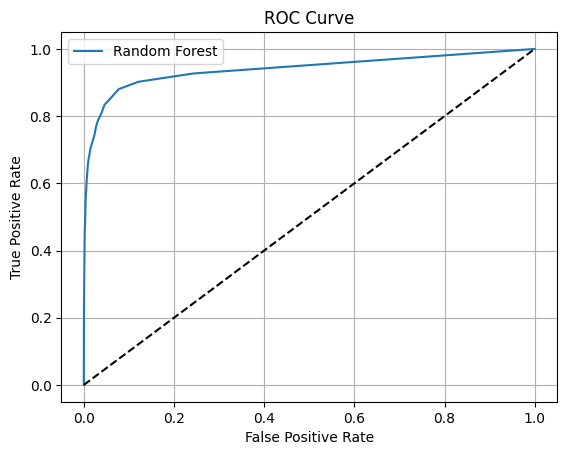

In [19]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


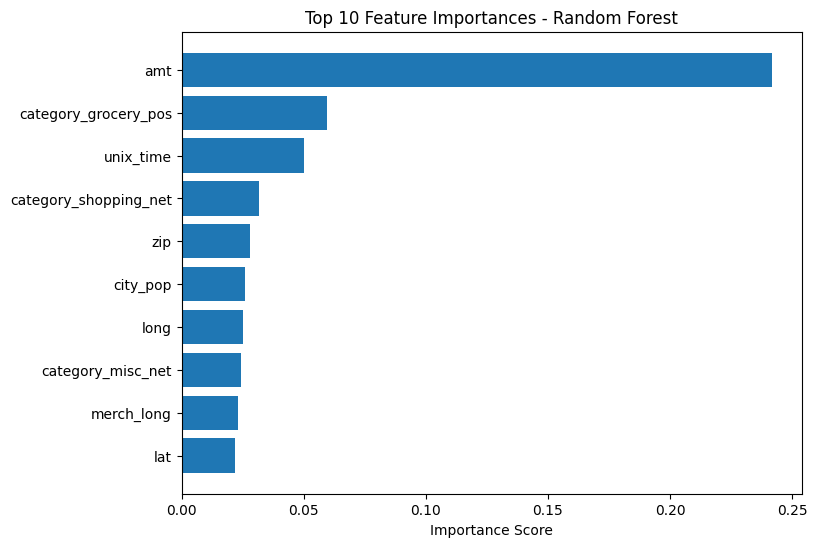

In [18]:
importances = models["Random Forest"].feature_importances_
features = X.columns
indices = np.argsort(importances)[-10:]  # top 10 features

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.show()